In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import os
import pandas as pd
import re
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering



In [2]:
def plot_heatmaps(data, num_slices=5):
    """
    Visualizes selected spectral slices as heatmaps using the Viridis colormap.

    Parameters:
    - data: 3D numpy array with shape (rows, cols, spectra).
    - num_slices: Number of evenly spaced spectral slices to visualize.
    """
    spectra_count = data.shape[2]
    slice_indices = np.linspace(0, spectra_count - 1, num_slices, dtype=int)

    fig, axes = plt.subplots(1, num_slices, figsize=(4 * num_slices, 4))
    for i, idx in enumerate(slice_indices):
        ax = axes[i] if num_slices > 1 else axes
        im = ax.imshow(data[:, :, idx], cmap='viridis', aspect='auto')
        ax.set_title(f'Spectral Slice {idx}')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


def plot_spectra(data):
    """
    Plots all spectra lines (one per spatial pixel) on a single graph.

    Parameters:
    - data: 3D numpy array with shape (rows, cols, spectra).
    """
    rows, cols, spectra_length = data.shape
    plt.figure(figsize=(10, 6))

    for i in range(rows):
        for j in range(cols):
            plt.plot(range(spectra_length), data[i, j, :], alpha=0.3)

    plt.title('All Spectra per Pixel')
    plt.xlabel('Spectral Index')
    plt.ylabel('Intensity')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()



def parse_h5_file(filepath):
    """
    Parses .h5 file to extract spectral data, spatial coordinates, and metadata.

    Parameters:
    - filepath: str, path to the .h5 file

    Returns:
    - data_array: 3D numpy array (x, y, spectra) for plotting
    - df_spectra: Pandas DataFrame with 'x', 'y', and spectral features
    - metadata: dict with parsed information from filename
    """

    # 1️⃣ Extract metadata from filename
    filename = filepath.split("/")[-1]
    metadata = parse_filename(filename)

    # 2️⃣ Load spectral data from .h5
    with h5py.File(filepath, "r") as file:
        # Adjust this path if other files have different structures
        data_array = file['stack']['measurement']['detector_00'][:]

    # 3️⃣ Convert 3D data into a DataFrame (pixels as rows, spectra as features)
    rows, cols, spectra_length = data_array.shape
    x_coords, y_coords = np.meshgrid(range(rows), range(cols), indexing='ij')

    df_spectra = pd.DataFrame(
        data_array.reshape(rows * cols, spectra_length),
        columns=[f'spec_{i}' for i in range(spectra_length)]
    )
    df_spectra.insert(0, 'y', y_coords.flatten())
    df_spectra.insert(0, 'x', x_coords.flatten())

    # 4️⃣ Add metadata as columns
    for key, value in metadata.items():
        df_spectra[key] = value

    return data_array, df_spectra, metadata


def parse_filename(filename):
    """
    Parses the filename to extract metadata based on known patterns.

    Parameters:
    - filename: str, filename with .h5 extension

    Returns:
    - dict with parsed metadata
    """
    filename = filename.replace(".h5", "")
    patterns = [
        r"(?P<sample>[A-Z])_L(?P<layer>\d+)_?(?P<run>\d+)?(?:\((?P<point>.*?)\))?",  # C_L01_02(Point3)
        r"(?P<instrument>[A-Z0-9]+)S(?P<section>\d+)_S(?P<scan>[\d\-]+)",           # HA7RF1S01_S4-5
        r"(?P<setting>[A-Z0-9]+)_(?P<iteration>\d+)_B(?P<block>\d+)"                # TR40L7_04_B4
    ]

    for pattern in patterns:
        match = re.match(pattern, filename)
        if match:
            return match.groupdict()

    return {"filename": filename}  # Default return if no pattern matched


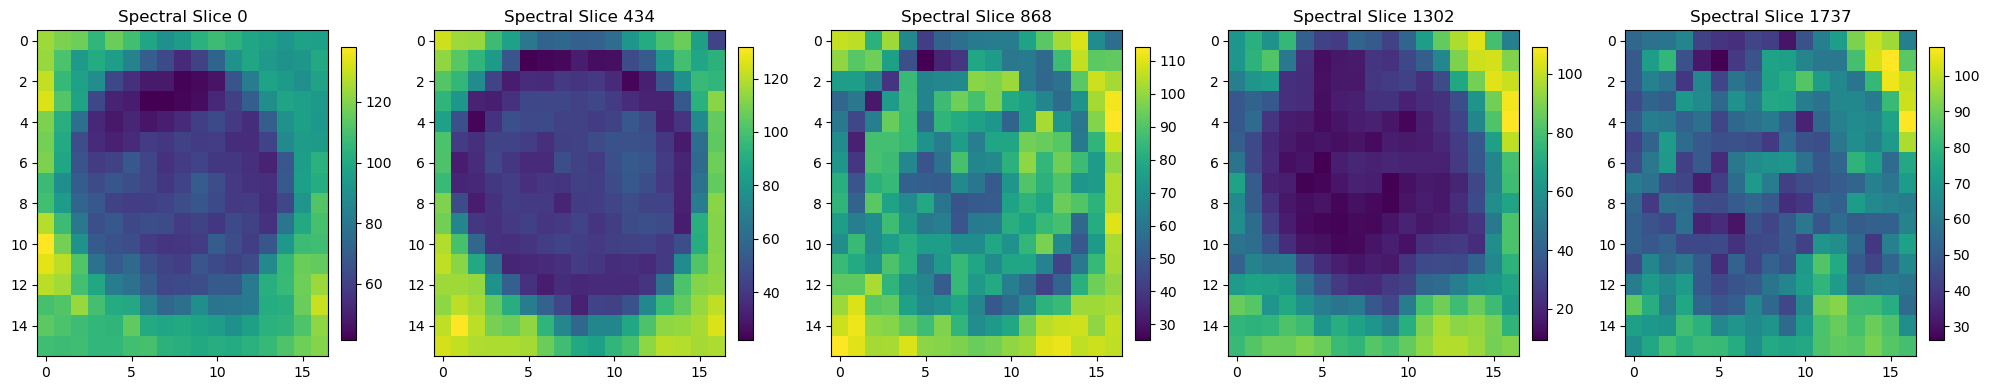

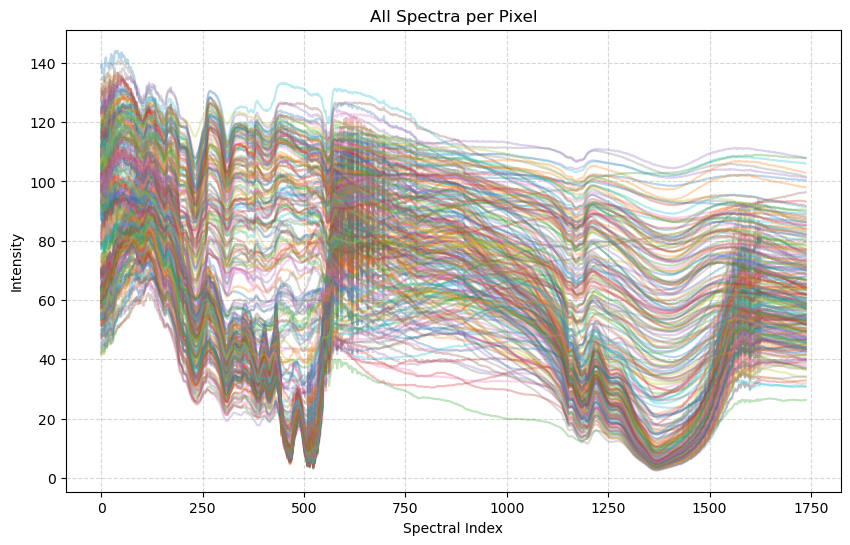

   x  y      spec_0      spec_1      spec_2      spec_3      spec_4  \
0  0  0  124.043205  124.286781  123.630104  123.407066  125.162491   
1  0  1  118.953430  119.790039  120.721970  120.348358  119.279358   
2  0  2  116.768959  114.421829  114.811722  116.575539  117.613289   
3  0  3  105.099831  105.166260  105.597794  104.933945  106.329330   
4  0  4  116.376755  116.625771  116.989204  114.865150  113.560677   

       spec_5      spec_6      spec_7  ...  spec_1732  spec_1733  spec_1734  \
0  125.148216  124.956802  123.272835  ...  54.127182  54.104519  54.025513   
1  117.179741  117.486809  118.190193  ...  57.276218  57.257641  57.217247   
2  120.600296  121.732224  117.674782  ...  58.234058  58.196831  58.181782   
3  106.509903  106.266739  105.769051  ...  63.945740  63.879322  63.839840   
4  114.305305  115.355095  113.166794  ...  42.628323  42.609253  42.567097   

   spec_1735  spec_1736  spec_1737  sample  layer  run   point  
0  53.990166  53.949810  53.92812

In [3]:
# Assuming plot_heatmaps and plot_spectra functions from earlier are available

# 1️⃣ Parse the .h5 file
file_path = 'C_L01_02(Point3).h5'
data_array, df_spectra, metadata = parse_h5_file(file_path)

# 2️⃣ Visualize heatmaps
plot_heatmaps(data_array, num_slices=5)

# 3️⃣ Visualize all spectra lines
plot_spectra(data_array)

# 4️⃣ Inspect structured DataFrame (for ML)
print(df_spectra.head())
print("Metadata extracted:", metadata)


In [4]:

def batch_load_h5(directory_path):
    """
    Loads all .h5 files in the given directory into a single DataFrame.

    Parameters:
    - directory_path: str, path to the folder containing .h5 files.

    Returns:
    - combined_df: Pandas DataFrame with all spectra and metadata.
    - file_list: List of file names processed.
    """
    combined_df = pd.DataFrame()
    file_list = []

    for file in os.listdir(directory_path):
        if file.endswith('.h5'):
            filepath = os.path.join(directory_path, file)
            data_array, df_spectra, metadata = parse_h5_file(filepath)
            df_spectra['file_id'] = file  # Add file identifier
            combined_df = pd.concat([combined_df, df_spectra], ignore_index=True)
            file_list.append(file)

    return combined_df, file_list


def plot_average_spectra(combined_df, file_list):
    """
    Plots average spectra for each file on the same graph.

    Parameters:
    - combined_df: DataFrame containing all data from batch_load_h5.
    - file_list: List of file names processed.
    """
    plt.figure(figsize=(12, 6))

    for file in file_list:
        file_df = combined_df[combined_df['file_id'] == file]
        spectra_cols = [col for col in file_df.columns if col.startswith('spec_')]
        avg_spectrum = file_df[spectra_cols].mean(axis=0)
        plt.plot(range(len(avg_spectrum)), avg_spectrum, label=file)

    plt.title("Average Spectra per File")
    plt.xlabel("Spectral Index")
    plt.ylabel("Average Intensity")
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


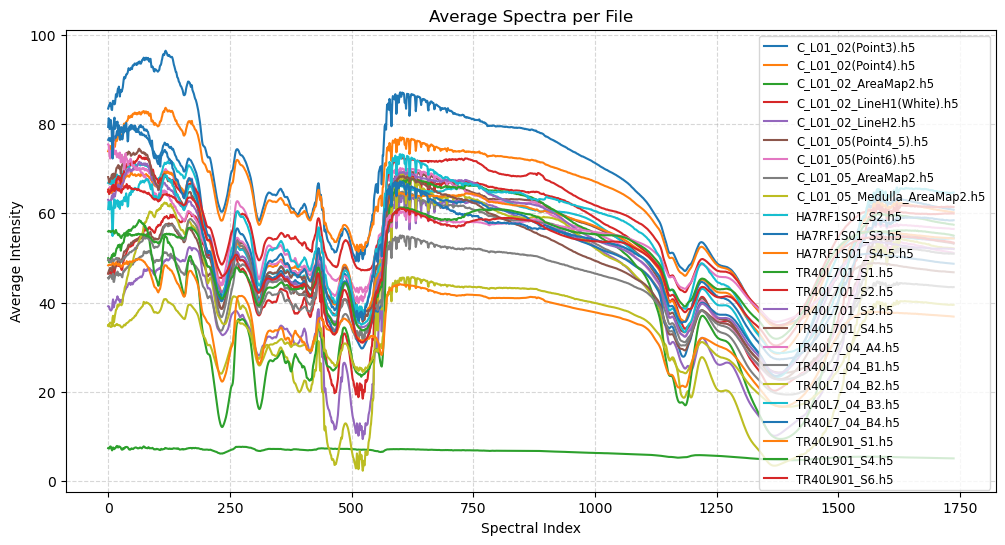

   x  y      spec_0      spec_1      spec_2      spec_3      spec_4  \
0  0  0  124.043205  124.286781  123.630104  123.407066  125.162491   
1  0  1  118.953430  119.790039  120.721970  120.348358  119.279358   
2  0  2  116.768959  114.421829  114.811722  116.575539  117.613289   
3  0  3  105.099831  105.166260  105.597794  104.933945  106.329330   
4  0  4  116.376755  116.625771  116.989204  114.865150  113.560677   

       spec_5      spec_6      spec_7  ...  run   point              file_id  \
0  125.148216  124.956802  123.272835  ...   02  Point3  C_L01_02(Point3).h5   
1  117.179741  117.486809  118.190193  ...   02  Point3  C_L01_02(Point3).h5   
2  120.600296  121.732224  117.674782  ...   02  Point3  C_L01_02(Point3).h5   
3  106.509903  106.266739  105.769051  ...   02  Point3  C_L01_02(Point3).h5   
4  114.305305  115.355095  113.166794  ...   02  Point3  C_L01_02(Point3).h5   

   instrument  section  scan  filename  setting  iteration  block  
0         NaN      NaN  

In [5]:
# Set directory path where .h5 files are stored
directory_path = './'  # Adjust to your path if needed

# 1️⃣ Load all files into a single DataFrame
combined_df, file_list = batch_load_h5(directory_path)

# 2️⃣ Plot average spectra for each file
plot_average_spectra(combined_df, file_list)

# 3️⃣ Inspect combined DataFrame
print(combined_df.head())
print(f"Processed {len(file_list)} files: {file_list}")


In [6]:
# Assuming `combined_df` is available from previous processing
pickle_path = 'combined_spectra.pkl'
csv_path = 'combined_spectra.csv'

# 1️⃣ Pickle the DataFrame
with open(pickle_path, 'wb') as pkl_file:
    pickle.dump(combined_df, pkl_file)

# 2️⃣ Convert to CSV
combined_df.to_csv(csv_path, index=False)

pickle_path, csv_path


('combined_spectra.pkl', 'combined_spectra.csv')

Wavenumber (cm 
−1
 )=1.9165×Index+650.00

In [8]:
#SCALING X to wavenumbers


original_df = pd.read_pickle("combined_spectra.pkl")
def add_wavenumber_scale(df):
    """
    Adds a new row (or separate reference) mapping spectral indices to wavenumbers.

    Parameters:
        df (pd.DataFrame): DataFrame containing spectral columns named 'spec_n'.

    Returns:
        pd.DataFrame: DataFrame with an additional column or separate series mapping indices to wavenumbers.
    """
    spec_columns = [col for col in df.columns if col.startswith('spec_')]
    indices = [int(col.split('_')[1]) for col in spec_columns]
    wavenumbers = [1.9165 * idx + 650.00 for idx in indices]

    # Creating a DataFrame for reference (recommended) or transposing as a separate row
    wavenumber_mapping = pd.DataFrame({
        'spectral_index': indices,
        'wavenumber_cm-1': wavenumbers
    })

    return wavenumber_mapping


wavenumber_mapping_df = add_wavenumber_scale(original_df)
wavenumber_mapping_df

,spectral_index,wavenumber_cm-1
0,0,650.0000
1,1,651.9165
2,2,653.8330
3,3,655.7495
4,4,657.6660
...,...,...
1733,1733,3971.2945
1734,1734,3973.2110
1735,1735,3975.1275
1736,1736,3977.0440


In [9]:
# Normalize the Y-values (spectral intensities) to range from 0 to 1
def normalize_spectra(df):
    """
    Normalizes spectral intensity values between 0 and 1 for each spectrum.

    Parameters:
        df (pd.DataFrame): DataFrame containing spectral data with columns starting with 'spec_'.

    Returns:
        pd.DataFrame: DataFrame with normalized spectral intensity values.
    """
    spec_columns = [col for col in df.columns if col.startswith('spec_')]
    spectra = df[spec_columns]
    
    # Normalize each spectrum individually
    df_normalized = df.copy()
    df_normalized[spec_columns] = (spectra - spectra.min(axis=1).values.reshape(-1, 1)) / \
                                  (spectra.max(axis=1) - spectra.min(axis=1)).values.reshape(-1, 1)
    return df_normalized

# Applying the normalization to the loaded DataFrame
normalized_df = normalize_spectra(original_df)

# Displaying a preview of normalized spectra
normalized_df.head()


,x,y,spec_0,spec_1,spec_2,spec_3,spec_4,spec_5,spec_6,spec_7,...,run,point,file_id,instrument,section,scan,filename,setting,iteration,block
0,0,0,0.896432,0.899446,0.891320,0.888561,0.910282,0.910106,0.907737,0.886900,...,02,Point3,C_L01_02(Point3).h5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,0.855996,0.867574,0.880471,0.875301,0.860506,0.831449,0.835698,0.845433,...,02,Point3,C_L01_02(Point3).h5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,0.861563,0.830709,0.835834,0.859020,0.872662,0.911927,0.926807,0.873470,...,02,Point3,C_L01_02(Point3).h5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,0.874194,0.875503,0.884008,0.870924,0.898427,0.901986,0.897193,0.887384,...,02,Point3,C_L01_02(Point3).h5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4,0.992646,0.995636,1.000000,0.974493,0.958829,0.967770,0.980377,0.954099,...,02,Point3,C_L01_02(Point3).h5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


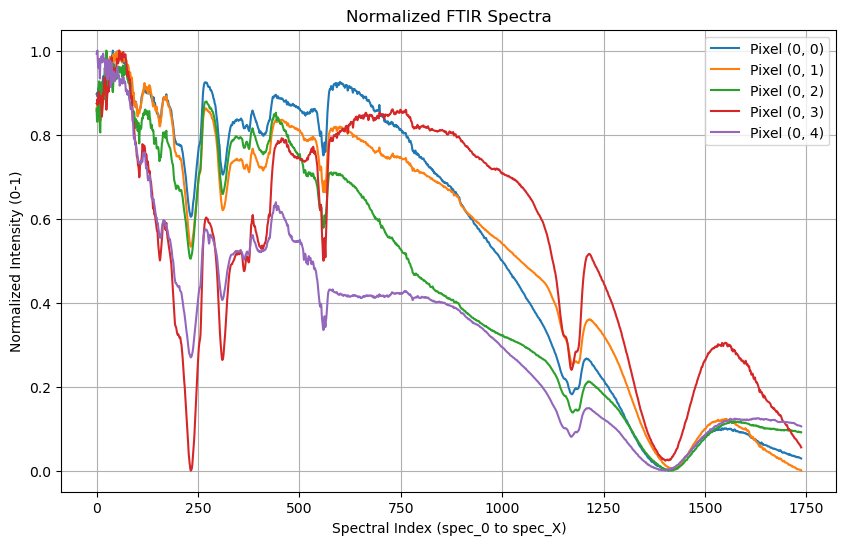

In [10]:
# Plotting normalized spectra for a selection of rows to visualize the results

plt.figure(figsize=(10, 6))

# Extract spectral columns and their indices
spec_columns = [col for col in normalized_df.columns if col.startswith('spec_')]
indices = [int(col.split('_')[1]) for col in spec_columns]

# Plot spectra for the first few pixels (rows)
for i in range(5):  # plotting the first 5 spectra
    plt.plot(indices, normalized_df.iloc[i][spec_columns], label=f"Pixel ({normalized_df.iloc[i]['x']}, {normalized_df.iloc[i]['y']})")

plt.xlabel('Spectral Index (spec_0 to spec_X)')
plt.ylabel('Normalized Intensity (0-1)')
plt.title('Normalized FTIR Spectra')
plt.legend()
plt.grid(True)
plt.show()


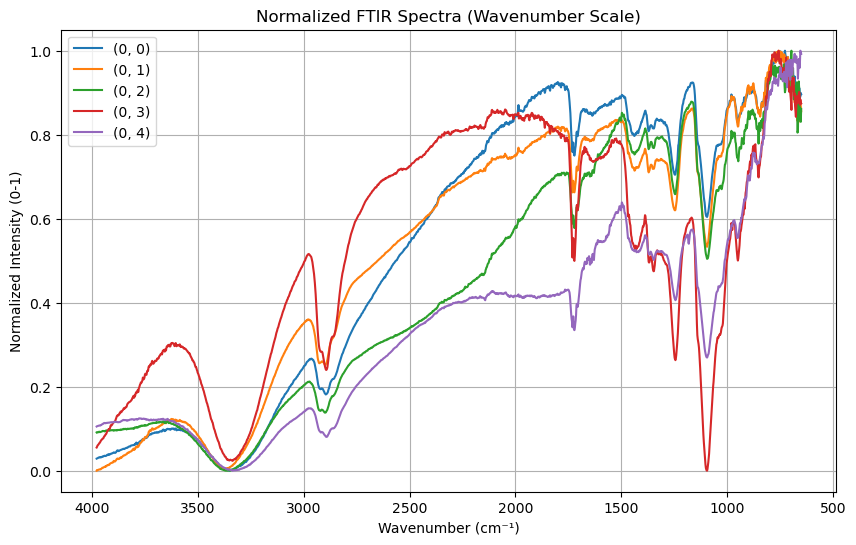

In [11]:
# Plotting normalized spectra with wavenumber mapping

plt.figure(figsize=(10, 6))

# Extract spectral columns and their indices
spec_columns = [col for col in normalized_df.columns if col.startswith('spec_')]
indices = np.array([int(col.split('_')[1]) for col in spec_columns])

# Apply the derived wavenumber formula to indices
wavenumbers = [1.9165 * idx + 650.00 for idx in indices]

# Plot spectra against wavenumber scale
for i in range(5):  # plotting first 5 spectra for clarity
    plt.plot(wavenumbers, normalized_df.iloc[i][spec_columns], 
             label=f"({normalized_df.iloc[i]['x']}, {normalized_df.iloc[i]['y']})")

plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Normalized Intensity (0-1)')
plt.title('Normalized FTIR Spectra (Wavenumber Scale)')
plt.gca().invert_xaxis()  # FTIR spectra typically plotted descending in wavenumber
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Function to replace spec_x columns with wavenumber values directly in the DataFrame

def rename_spec_columns_to_wavenumbers(df):
    """
    Renames spec columns from 'spec_x' format to their corresponding wavenumber values.
    
    Parameters:
        df (pd.DataFrame): DataFrame with spec columns to rename.
    
    Returns:
        pd.DataFrame: DataFrame with renamed columns.
    """
    spec_columns = [col for col in df.columns if col.startswith('spec_')]
    mapping = {col: f"{1.9165 * int(col.split('_')[1]) + 650:.2f}" for col in spec_columns}
    df_renamed = df.rename(columns=mapping)
    return df_renamed

# Apply renaming
df_with_wavenumbers = rename_spec_columns_to_wavenumbers(normalized_df)

# Display updated DataFrame structure
df_with_wavenumbers.head()


,x,y,650.00,651.92,653.83,655.75,657.67,659.58,661.50,663.42,...,run,point,file_id,instrument,section,scan,filename,setting,iteration,block
0,0,0,0.896432,0.899446,0.891320,0.888561,0.910282,0.910106,0.907737,0.886900,...,02,Point3,C_L01_02(Point3).h5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,0.855996,0.867574,0.880471,0.875301,0.860506,0.831449,0.835698,0.845433,...,02,Point3,C_L01_02(Point3).h5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,0.861563,0.830709,0.835834,0.859020,0.872662,0.911927,0.926807,0.873470,...,02,Point3,C_L01_02(Point3).h5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,0.874194,0.875503,0.884008,0.870924,0.898427,0.901986,0.897193,0.887384,...,02,Point3,C_L01_02(Point3).h5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4,0.992646,0.995636,1.000000,0.974493,0.958829,0.967770,0.980377,0.954099,...,02,Point3,C_L01_02(Point3).h5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Assuming `combined_df` is available from previous processing
pickle_path = 'spectra_scaled.pkl'
csv_path = 'spectra_scaled.csv'

# 1️⃣ Pickle the DataFrame
with open(pickle_path, 'wb') as pkl_file:
    pickle.dump(df_with_wavenumbers, pkl_file)

# 2️⃣ Convert to CSV
df_with_wavenumbers.to_csv(csv_path, index=False)

pickle_path, csv_path


('spectra_scaled.pkl', 'spectra_scaled.csv')

# BEGIN LOOKING HERE

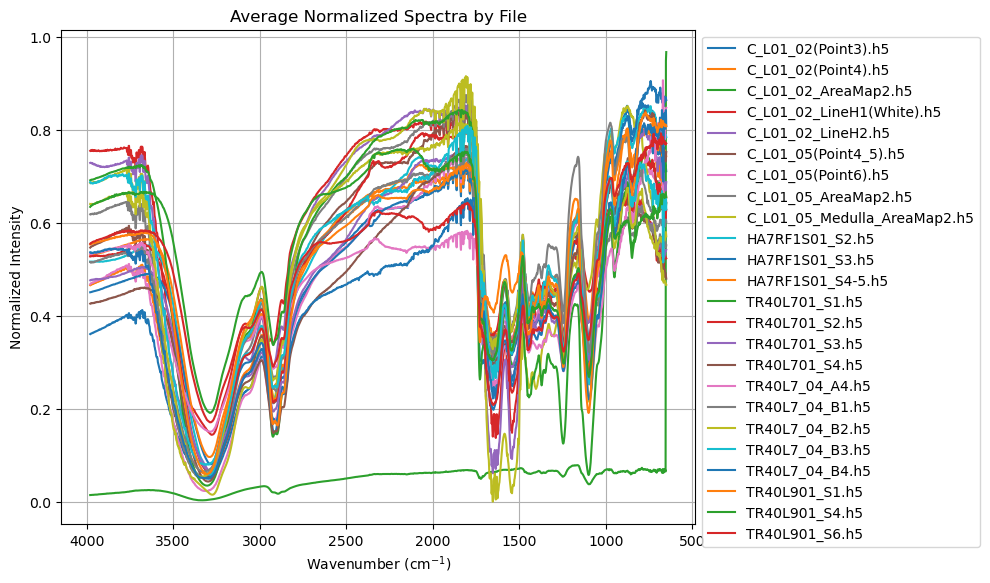

In [16]:
# Re-plotting with the legend moved outside the plotting area for clear visibility

plt.figure(figsize=(10, 6))
spectral_columns = [col for col in df_with_wavenumbers.columns if col.replace('.', '', 1).isdigit()]


# Plotting average spectra for each file
for file_id, group_df in df_with_wavenumbers.groupby('file_id'):
    avg_spectrum = group_df[spectral_columns].mean()
    plt.plot([float(wn) for wn in spectral_columns], avg_spectrum, label=file_id)

plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Normalized Intensity')
plt.title('Average Normalized Spectra by File')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside plot for clarity
plt.gca().invert_xaxis()  # FTIR convention: wavenumber decreasing left to right
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
from sklearn.cluster import KMeans

# Clustering spectral data into 10 groups (arbitrary initial choice, adjustable)
def cluster_spectra(df, spectral_columns, n_clusters=10):
    from sklearn.cluster import KMeans

    spectra_data = df[spectral_columns].values
    clustering_model = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster_label'] = clustering_model.fit_predict(spectra_data)

    return df, clustering_model

# Apply clustering to normalized spectral data (all spectra, blind of file_id)
df_clustered, clustering_model = cluster_spectra(df_with_wavenumbers, spectral_columns)

# Preview clustering results
df_with_clusters = df_with_wavenumbers[['x', 'y', 'cluster_label']].head()
df_with_clusters_preview = df_with_wavenumbers[['x', 'y', 'cluster_label']].head()
df_with_clusters_preview.head()


,x,y,cluster_label
0,0,0,2
1,0,1,2
2,0,2,2
3,0,3,9
4,0,4,5


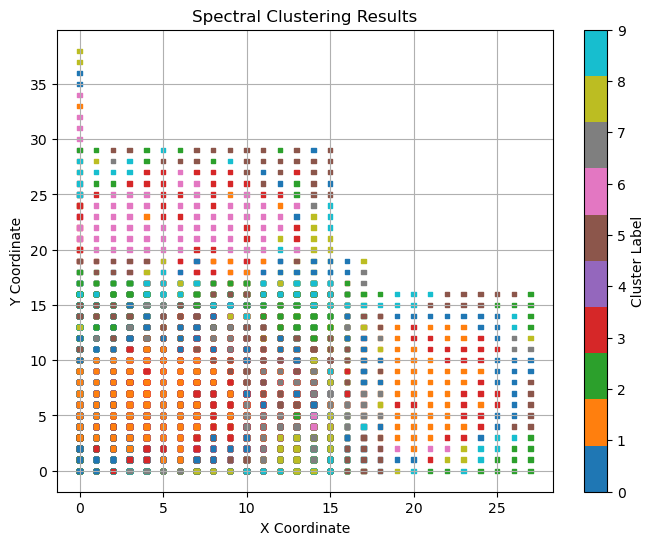

In [20]:
def plot_clusters(df):
    """
    Plots the clustered spectra spatially using the 'x' and 'y' coordinates.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'x', 'y', and 'cluster_label' columns.
    """
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df['x'], df['y'], c=df['cluster_label'], cmap='tab10', marker='s', s=10)
    plt.colorbar(scatter, label="Cluster Label")
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Spectral Clustering Results')
    plt.grid(True)
    plt.show()

plot_clusters(df_clustered)

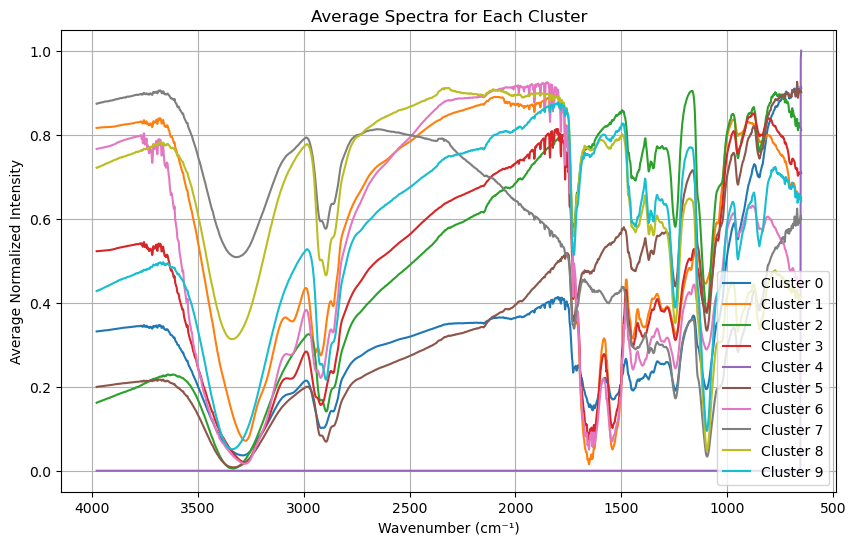

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_average_spectra_by_cluster(df, spectral_columns):
    """
    Plots the average spectra for each cluster.

    Parameters:
        df (pd.DataFrame): DataFrame containing spectral data and cluster labels.
        spectral_columns (list): List of column names corresponding to spectral data.
    """
    plt.figure(figsize=(10, 6))

    # Identify unique clusters and compute the average spectrum for each
    for cluster in sorted(df['cluster_label'].unique()):
        cluster_df = df[df['cluster_label'] == cluster]
        avg_spectrum = cluster_df[spectral_columns].mean()

        # Convert spectral column names (wavenumbers) to float for proper plotting
        wavenumbers = [float(w) for w in spectral_columns]
        plt.plot(wavenumbers, avg_spectrum, label=f"Cluster {cluster}")

    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Average Normalized Intensity')
    plt.title('Average Spectra for Each Cluster')
    plt.legend()
    plt.gca().invert_xaxis()  # FTIR convention: decreasing wavenumber
    plt.grid(True)
    plt.show()

# Usage:
plot_average_spectra_by_cluster(df_clustered, spectral_columns)


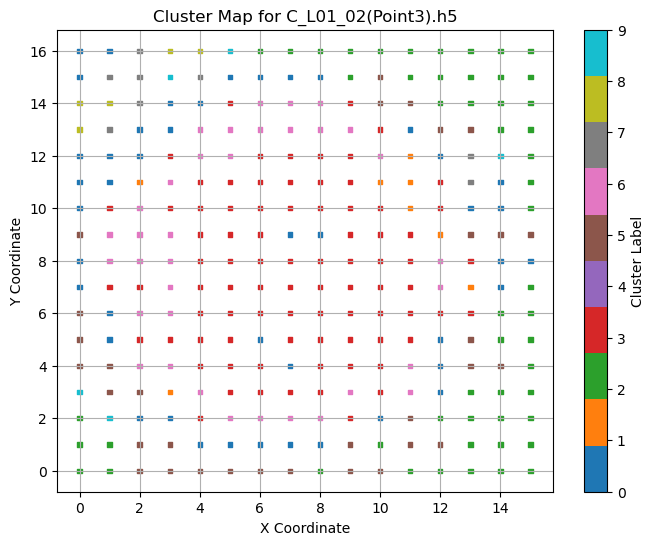

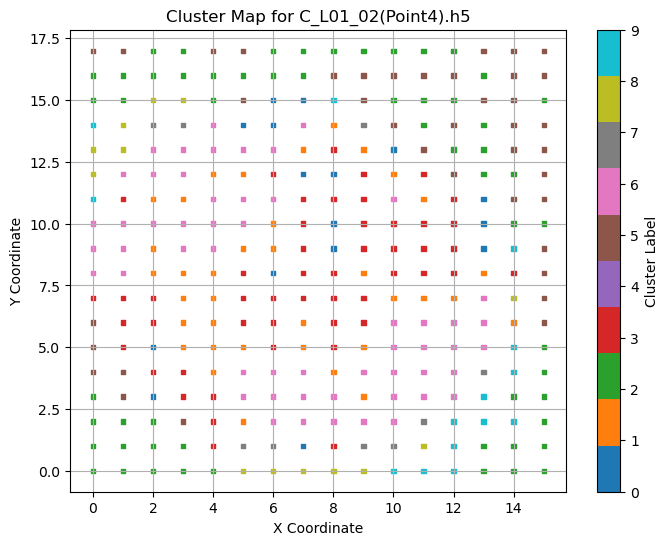

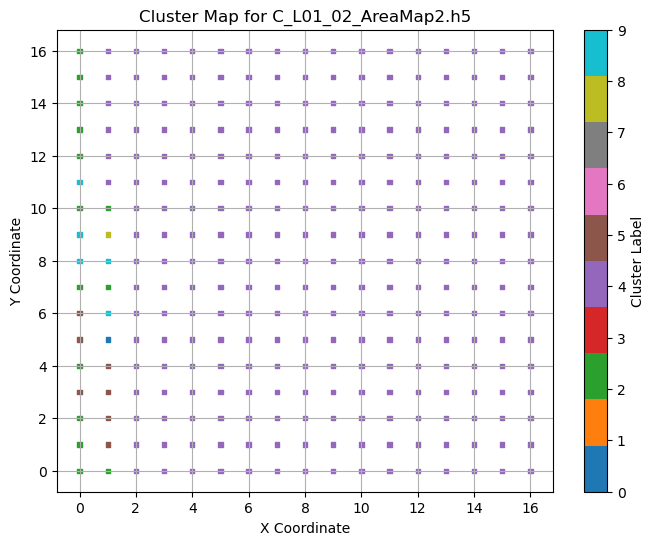

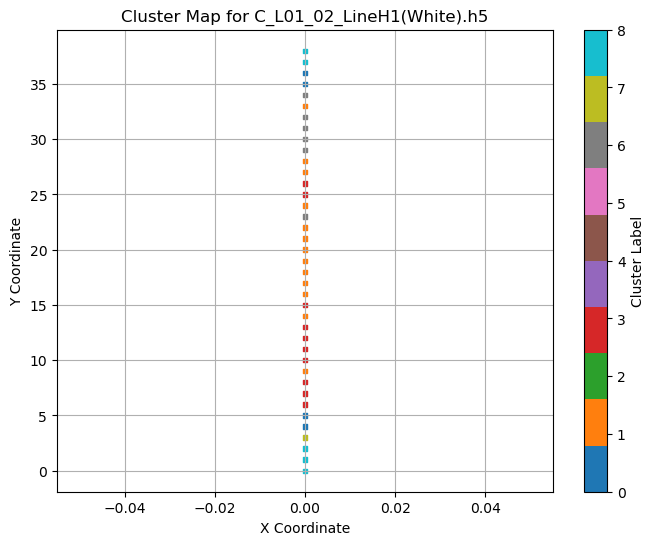

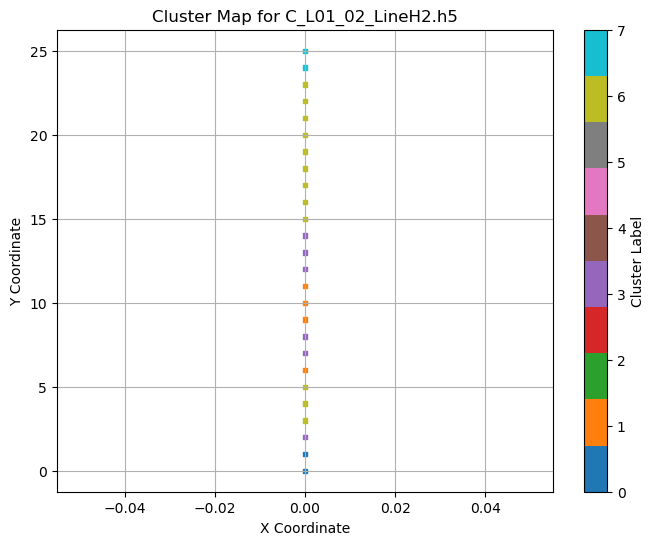

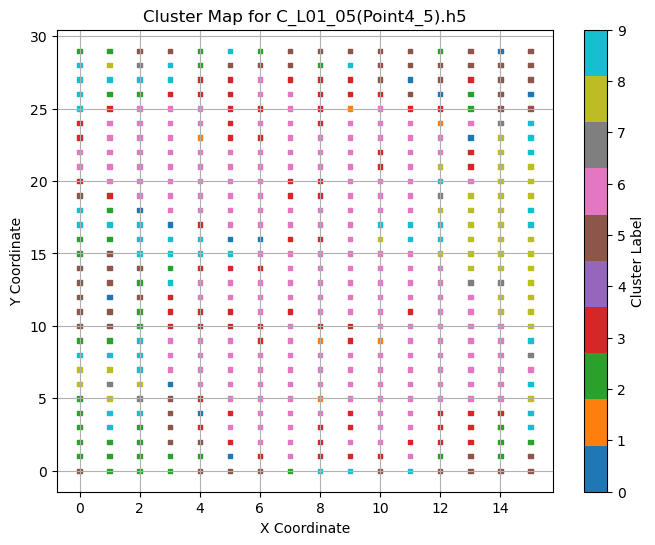

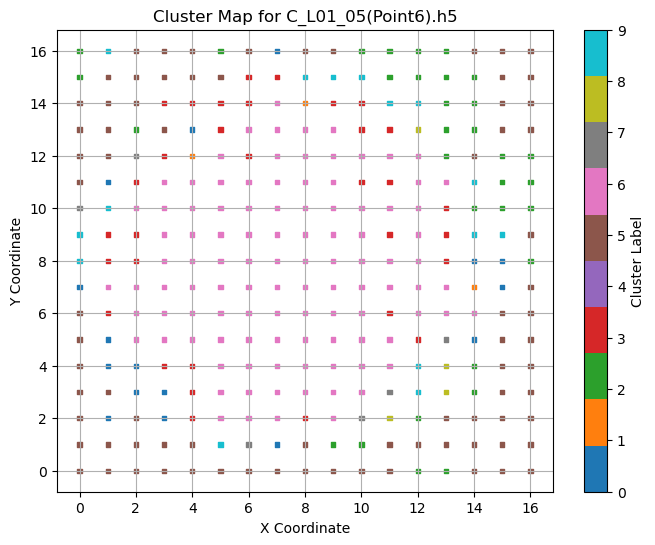

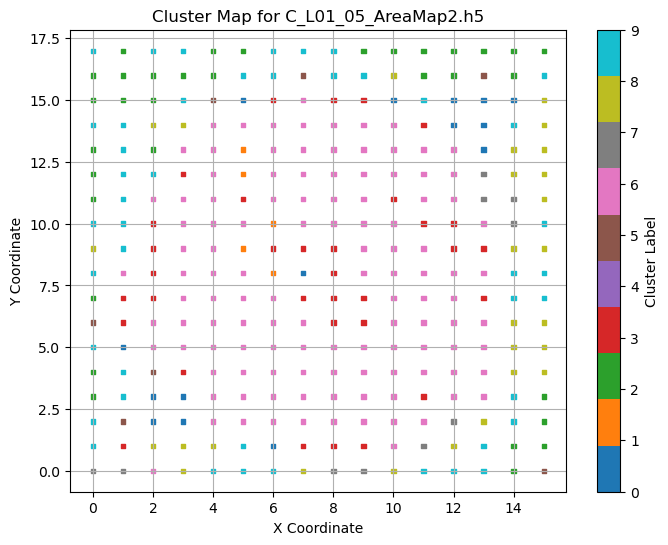

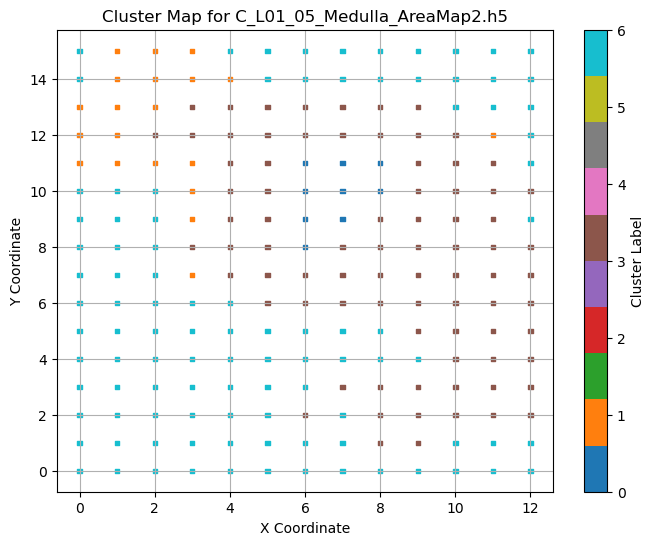

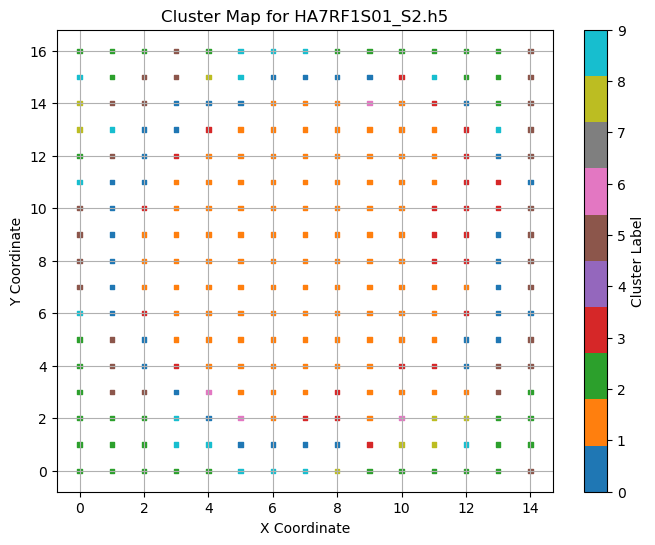

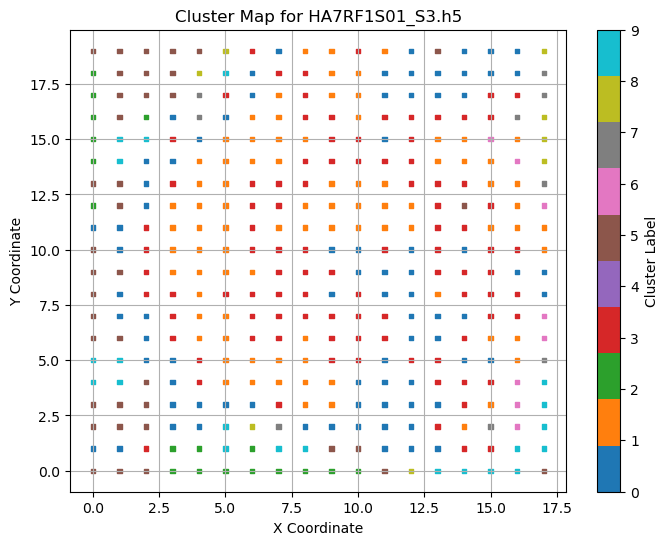

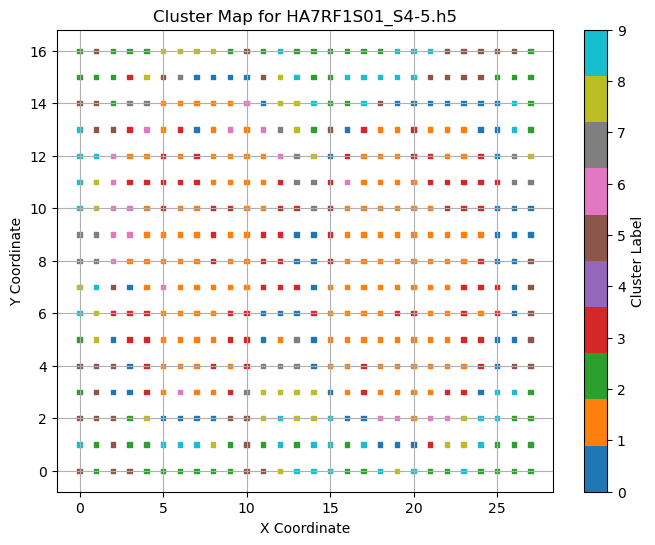

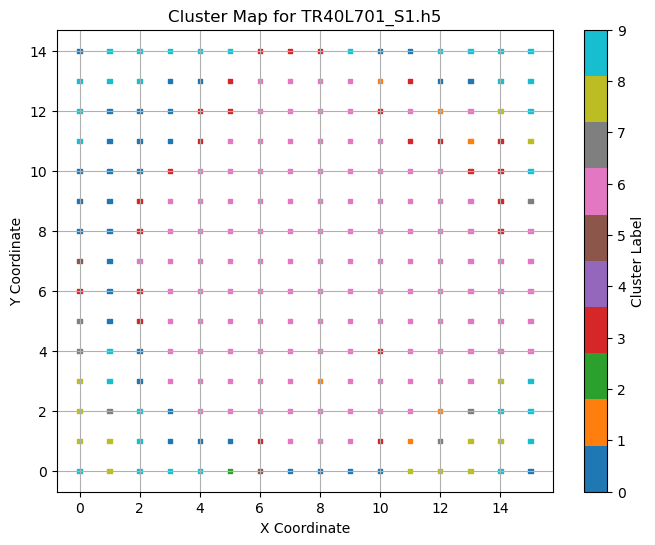

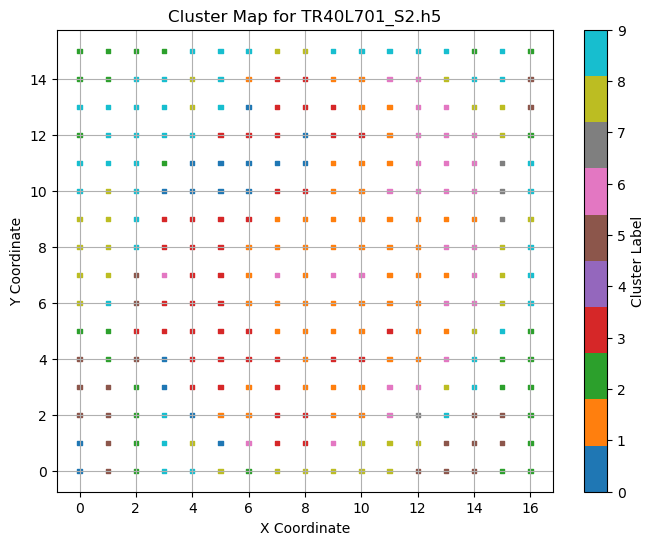

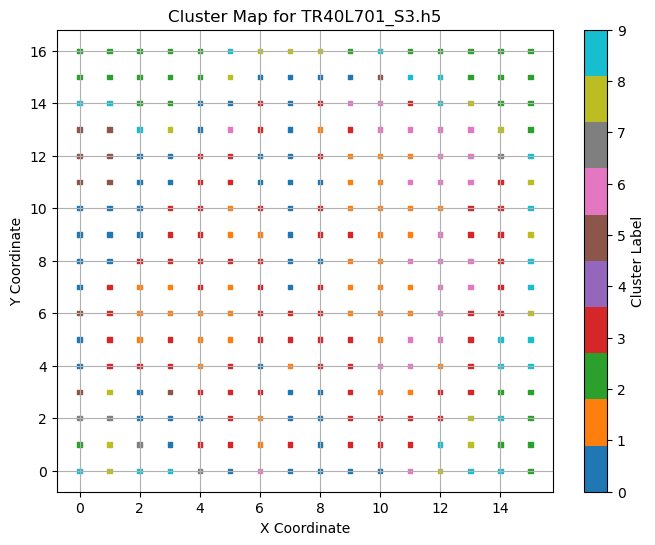

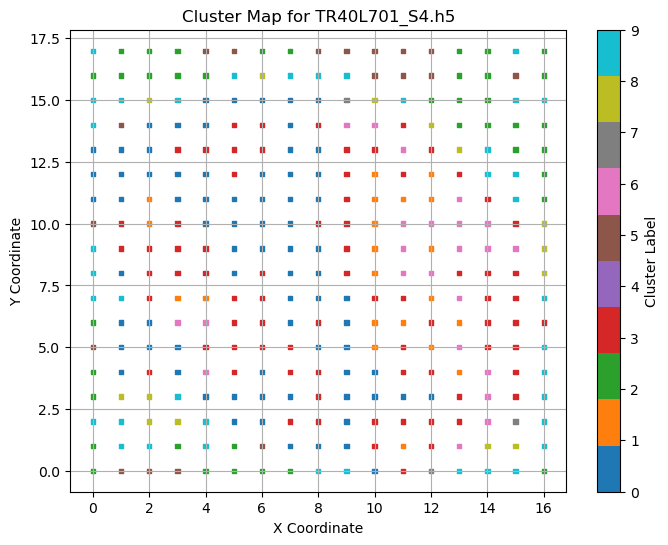

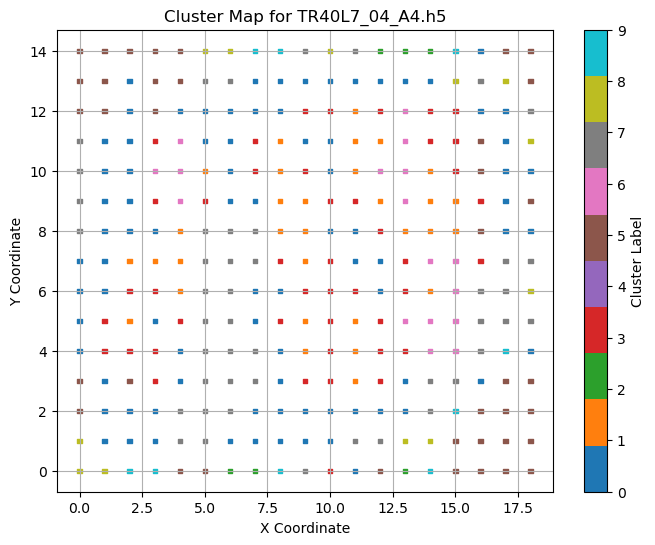

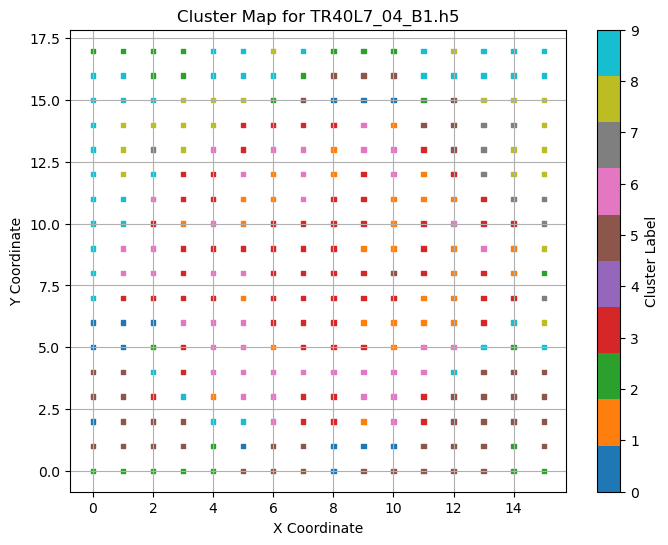

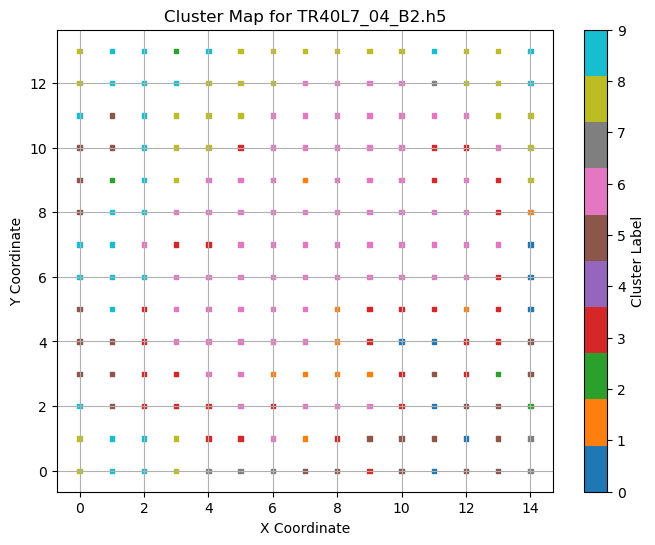

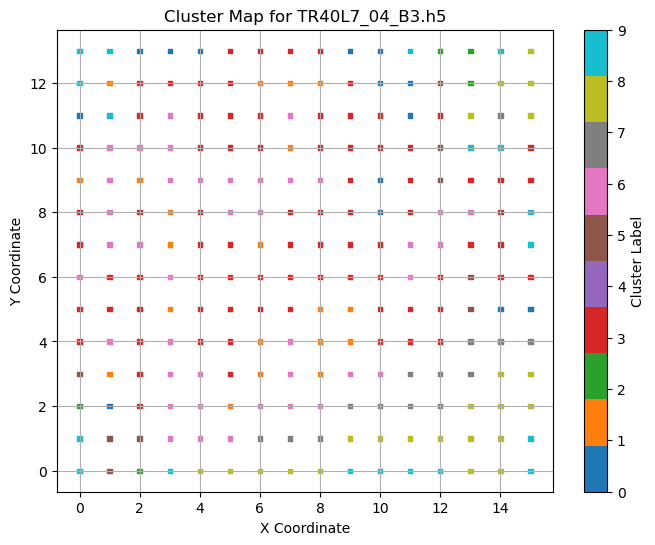

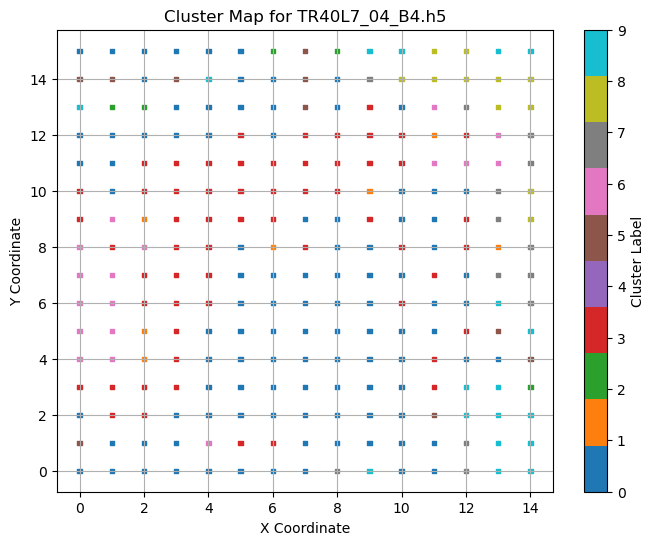

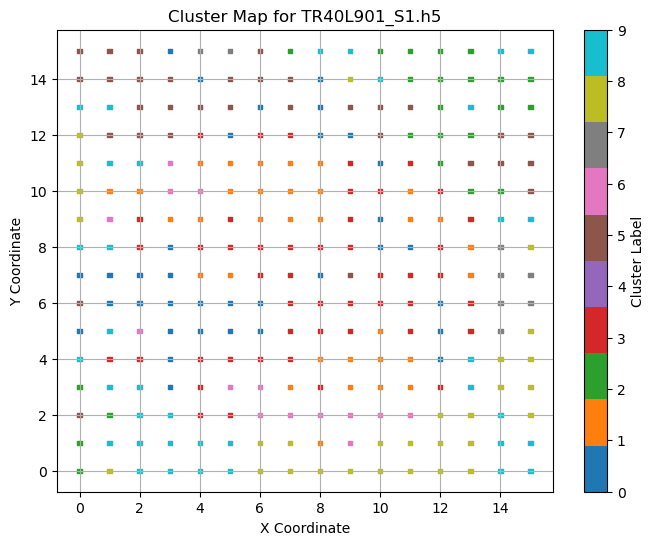

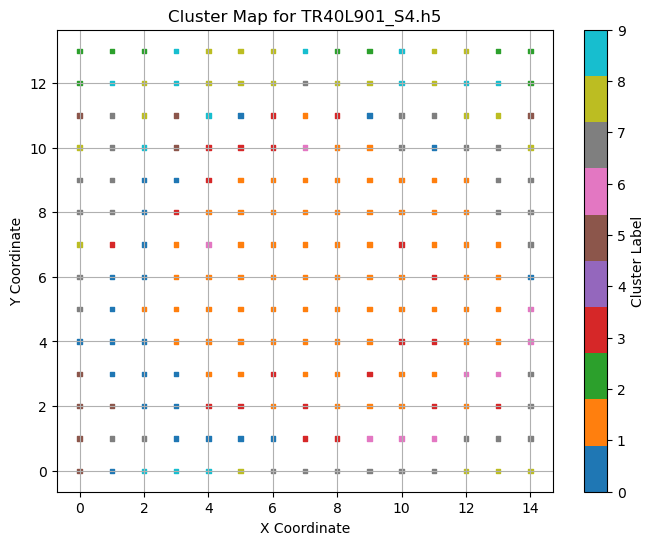

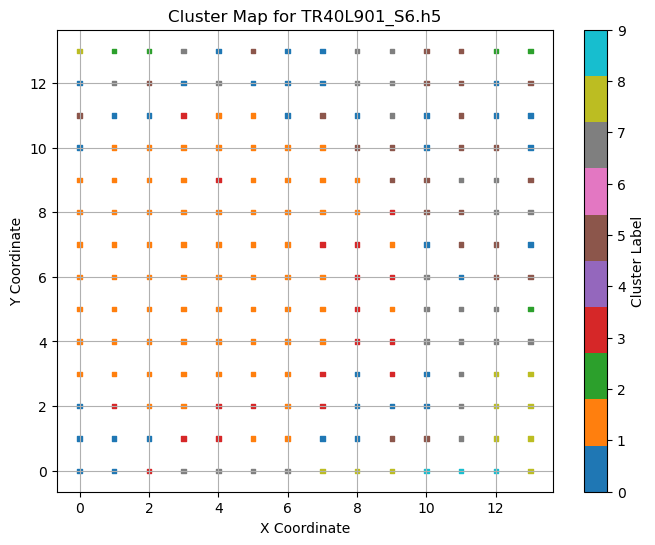

In [23]:
import matplotlib.pyplot as plt

def plot_clusters_per_file(df):
    """
    Plots the spatial distribution of clusters for each unique filename.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'x', 'y', 'cluster_label', and 'file_id' columns.
    """
    unique_files = df['file_id'].unique()
    
    for file_id in unique_files:
        plt.figure(figsize=(8, 6))
        file_df = df[df['file_id'] == file_id]
        
        scatter = plt.scatter(file_df['x'], file_df['y'], c=file_df['cluster_label'], cmap='tab10', marker='s', s=10)
        plt.colorbar(scatter, label="Cluster Label")
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.title(f'Cluster Map for {file_id}')
        plt.grid(True)
        plt.show()

# Usage:
plot_clusters_per_file(df_clustered)
